Install CUDA version of the BLAS libraries

In [1]:
!pip install vanilla

Install the 'vanilla' pennylane package first.

In [2]:
!pip install pennylane

Now we build the "lightning" and "lightning-gpu" device code from source. We could probably use pre-packaged versions but this is what i managed to get working. I'll play with using the pre-packaged versions sometime soon.

In [3]:
!python -m pip install wheel custatevec-cu11

ERROR: Could not find a version that satisfies the requirement custatevec-cu11 (from versions: none)
ERROR: No matching distribution found for custatevec-cu11


In [4]:
import os
import site
os.environ["CUQUANTUM_SDK"] = f'{site.getsitepackages()[0]}/cuquantum/lib'

In [5]:
!PL_BACKEND="lightning_gpu" python -m pip install -e . -vv

'PL_BACKEND' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

import pennylane as qml
from pennylane import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Note that here we make use of the "lightning.gpu" device in order to have the pennylane code access the GPU.  Also a couple of lines to test that it's actually doing what's expected.

In [7]:
n_qubits = 4
if use_cuda is True:
    dev = qml.device("lightning.gpu", wires=n_qubits)
else:
    dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

print(f"{dev=}")

input = torch.from_numpy(np.random.uniform(0, np.pi, (4,))).to(device)
weights = torch.from_numpy(np.random.uniform(0, np.pi, (4, 4))).to(device)
output = circuit(input, weights)
print(f"{output=}")

dev=<default.qubit device (wires=4) at 0x24b236302d0>
output=[tensor(-0.5907, dtype=torch.float64), tensor(0.2477, dtype=torch.float64), tensor(0.2684, dtype=torch.float64), tensor(-0.2593, dtype=torch.float64)]


### Load MNIST Dataset

Note that the images are resized to 14x14 here.

In [8]:
import torch
from torchvision import datasets, transforms
# Loading of the MNIST dataset

transformations = transforms.Compose(
    [transforms.Resize(14),
     transforms.ToTensor()]
)
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transformations,
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformations
)

### Model Hyper-Parameters

In [9]:
#Setting of the main hyper-parameters of the model
batch_size = 4
n_train = batch_size * 125    # Size of the train dataset
n_test = batch_size * 25     # Size of the test dataset
n_channels = 4
initial_lr = 0.003          # Define your initial learning rate
num_epochs = 40

Note that in the 'quanv' function we need to copy the 'image' and 'weights' data to the CPU memory before converting to numpy arrays. There may be scope for further optimisation here but at the moment it seems that the PyTorch code requires it.

In [10]:
def quanv(image, weights):
    """Convolves the input image with many applications of the same quantum circuit."""
    # PyTorch models generally require a 4D input tensor with the
    # dimensions - (batch size, channels, height, width)
    # input image shape is (batch_size, 1, 14, 14)
    # output shape should be (batch_size, 4, 7, 7)
    out = np.zeros((batch_size, 4, 7, 7))
    l_image = image.detach().cpu().numpy()
    l_weights = weights.detach().cpu().numpy()

    for i in range(batch_size):
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, 14, 2):
            for k in range(0, 14, 2):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit(
                    [
                        l_image[i, 0, j, k] * np.pi,
                        l_image[i, 0, j, k + 1] * np.pi,
                        l_image[i, 0, j + 1, k] * np.pi,
                        l_image[i, 0, j + 1, k + 1] * np.pi
                    ],
                    l_weights
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(n_channels):
                    out[i, c, j // 2, k // 2] = q_results[c]
    return out

Note that in the HybridFunction.forward method we need to copy the output from 'quanv' to GPU memory. That's done by the '.to(device)' call.  Likewise for the initial values of the 'weights' parameters.

In [11]:
# Custom nn.Module class for handling the quantum convolution
class QuantConv(nn.Module):

    # The number of layers in the BasicEntanglerLayers instance in
    # the quantum convolver
    LAYERS = 4

    def __init__(self):
        super(QuantConv, self).__init__()
        # Initialise and register weights
        # weights have shape (LAYERS, n_qubits) where LAYERS is the
        # number of layers in the BasicEntanglerLayers
        self.weights = nn.Parameter(
            torch.from_numpy(np.random.uniform(
                0, np.pi, (QuantConv.LAYERS, n_qubits)))).to(device)

    def forward(self, input):
        expectation_z = quanv(input, self.weights)
        x = torch.tensor(expectation_z).to(device)
        return x


In [12]:
class QuantModel(nn.Module):
    def __init__(self):
        super(QuantModel, self).__init__()
        self.qconv = QuantConv()
        self.fc1 = nn.Linear(4 * 7 * 7, 10)
        self.double()

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.qconv(x)
        # Flatten the output from the convolutional layer
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return x

The following isn't strictly necessary but it makes for a 'sanity' check on the code. Note that inputs and labels are copied to GPU memory before calling quanv. This is also done in the training loop.

In [13]:
# Run the quanv function on a batch of images
dataset  = train_data
train_size = n_train
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
for data in train_loader:
    inputs, labels = data
    print(f"{inputs.shape=}")
    print(f"{labels=}")
    labels = labels.repeat_interleave(n_channels)
    inputs, labels = inputs.to(device), labels.to(device)
    weights = torch.from_numpy(np.random.uniform(0, np.pi, (4, 4)))
    outputs = quanv(inputs, weights)
    print(f"Repeated {labels=}")
    print(f"{outputs.shape=}")
    #print(f"{outputs=}")
    break

inputs.shape=torch.Size([4, 1, 14, 14])
labels=tensor([3, 5, 4, 4])
Repeated labels=tensor([3, 3, 3, 3, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4])
outputs.shape=(4, 4, 7, 7)


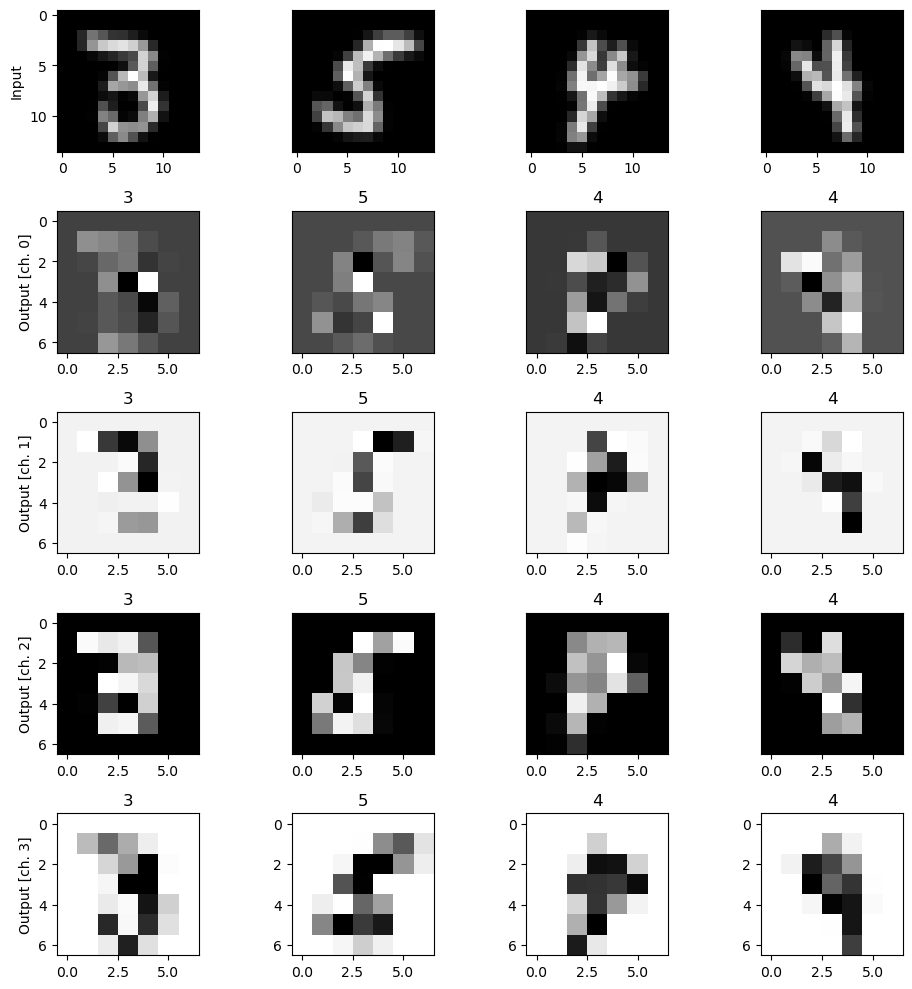

In [14]:
# Visualise the inputs/outputs from the quanv function
l_inputs = inputs.cpu()
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(l_inputs[k, 0, :, :], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].set_title(f"{labels[c+(k*n_samples)]}")
        axes[c + 1, k].imshow(outputs[k, c, :, :], cmap="gray")

plt.tight_layout()
plt.show()

### Create Data Loaders

Data loaders for both the training and test/validation datasets are created here. In both cases, a random selection of n_train and n_test objects are taken from the full MNIST dataset.

The indices of the selected objects are saved to a file ("dataset_indices.pt") so they can be reused at a later time if desired. The REGENERATE_INDICES_FILE should be set to *False* if a previously saved set of dataset indices is to be used and set to *True* if a new randomly selected set of indices should be used.

Note that on colab, any saved index files should be downloaded to your local computer since colab will delete such files when the session is disconnected.

In [15]:
import os
from pathlib import Path
from torch.utils.data import Subset, DataLoader
import torch

# Set the working directory to your project folder
os.chdir("C:/Users/harsh/Desktop/hybrid-quantum-classical-models-for-image-classification-main")

# Create a models directory if it doesn't exist
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Path for the subset indices file
SUBSET_INDICES_FILE = Path("C:/Users/harsh/Desktop/hybrid-quantum-classical-models-for-image-classification-main/hybrid-quantum-classical-models-for-image-classification-main/dataset_indices_500.pt")

# Set your desired training and testing sizes
n_train = 1000  # Adjust as needed
n_test = 200    # Adjust as needed
batch_size = 32 # Adjust as needed

# Load the subset indices from the specified file
subset_indices_dict = torch.load(SUBSET_INDICES_FILE)

# Create subsets using the loaded indices
train_subset = Subset(train_data, subset_indices_dict['train_indices'])
test_subset = Subset(test_data, subset_indices_dict['test_indices'])

# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)  # Shuffling the training data is typical
val_loader = DataLoader(test_subset, shuffle=False, batch_size=batch_size)

# Print the sizes of the subsets
print(f"{len(train_subset)=}")
print(f"{len(test_subset)=}")


len(train_subset)=500
len(test_subset)=100


C:\Users\harsh\AppData\Local\Temp\ipykernel_10836\4181983067.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  subset_indices_dict = torch.load(SUBSET_INDICES_FILE)


### Training Loop

In [16]:
import datetime
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define parameters
initial_lr = 0.01  # Learning rate
num_epochs = 10    # Number of epochs
batch_size = 32    # Batch size

# Initialize your QCNN model
cnn = QuantModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=initial_lr, momentum=0.9)

# Create a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0)

# Load train data
train_loader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)

MODEL_NAME = "ImgClass-Quanvolv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

RESUME_TRAINING = False

if RESUME_TRAINING:
    print(f"Restore model state from {MODEL_SAVE_PATH}")
    model_dict = torch.load(MODEL_SAVE_PATH)
    initial_epoch = model_dict['epoch'] + 1
    cnn.load_state_dict(model_dict['model_state_dict'])
    optimizer.load_state_dict(model_dict['optimizer_state_dict'])
    loss_list = model_dict['loss'].copy()
else:
    initial_epoch = 0
    loss_list = []

for epoch in range(initial_epoch, num_epochs):
    cnn.train()
    ct = datetime.datetime.now()
    lr = scheduler.get_last_lr()
    print(f"{epoch=}, {lr=}, {ct}")
    running_loss = []

    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Check input shape
        if inputs.ndim == 3:  # If the input is missing the channel dimension
            inputs = inputs.unsqueeze(1)  # Add channel dimension

        # Ensure inputs and labels are on the correct device
        inputs, labels = inputs.to(device), labels.to(device)

        # Check for correct batch size
        if inputs.size(0) != batch_size:
            print(f"Warning: Expected batch size {batch_size}, but got {inputs.size(0)}")
            continue  # Skip this batch if size does not match

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = cnn(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        running_loss.append(loss.item())
        optimizer.step()  # Update the model parameters

    loss_list.append(sum(running_loss) / len(running_loss))

    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / num_epochs, loss_list[-1]))

    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_list,
    }, MODEL_SAVE_PATH)
    print(f"Saving model state to {MODEL_SAVE_PATH}")

    # Validation
    val_loader = DataLoader(test_subset, shuffle=False, batch_size=batch_size)
    correct = 0
    total = 0
    cnn.eval()

    with torch.inference_mode():
        for data in val_loader:
            images, labels = data
            if images.ndim == 3:  # Ensure images have the channel dimension
                images = images.unsqueeze(1)  # Add channel dimension if missing

            images, labels = images.to(device), labels.to(device)

            # Check for correct batch size
            if images.size(0) != batch_size:
                print(f"Warning: Expected batch size {batch_size}, but got {images.size(0)}")
                continue  # Skip this batch if size does not match

            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')

    # Decay Learning Rate
    scheduler.step()

print('Finished Training')


epoch=0, lr=[0.01], 2024-10-15 20:50:21.894638
Training [10%]	Loss: 2.2998
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 14.58%
epoch=1, lr=[0.01], 2024-10-15 21:04:50.149547
Training [20%]	Loss: 2.2796
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 17.71%
epoch=2, lr=[0.01], 2024-10-15 21:17:13.935418
Training [30%]	Loss: 2.2584
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 17.71%
epoch=3, lr=[0.01], 2024-10-15 21:26:23.012024
Training [40%]	Loss: 2.2406
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 17.71%
epoch=4, lr=[0.01], 2024-10-15 21:35:38.532025
Training [50%]	Loss: 2.2234
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 18.75%
epoch=5, lr=[0.01], 2024-10-15 21:44:33.204430
Training [60%]	Loss: 2.2051
Saving model state to models\ImgClass-Quanvolv.pth
Accuracy on the validation set: 20.83%
epoch=6, l

In [17]:
print(f"Input shape: {input.shape}")


Input shape: torch.Size([4])


### Model Inference

The problem with the 'IndexError' exception has now been fixed.

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the accuracy calculation function
def calculate_accuracy(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = 100 * correct / total if total > 0 else 0
    return accuracy

# Define the metrics calculation function
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return precision, recall, f1

# Your existing training and model code goes here...

# Validation
val_loader = DataLoader(test_subset, shuffle=False, batch_size=batch_size)
y_true = []
y_pred = []
cnn.eval()

with torch.inference_mode():
    for data in val_loader:
        images, labels = data
        if images.ndim == 3:  # Ensure images have the channel dimension
            images = images.unsqueeze(1)  # Add channel dimension if missing

        images, labels = images.to(device), labels.to(device)

        # Check for correct batch size
        if images.size(0) != batch_size:
            print(f"Warning: Expected batch size {batch_size}, but got {images.size(0)}")
            continue  # Skip this batch if size does not match

        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)

        # Store true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = calculate_accuracy(torch.tensor(y_pred), torch.tensor(y_true))
print(f'Accuracy on the validation set: {accuracy:.2f}%')

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_metrics(np.array(y_true), np.array(y_pred))
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')


Accuracy on the validation set: 29.17%
Precision: 0.14, Recall: 0.29, F1 Score: 0.17
